<a href="https://colab.research.google.com/github/ggp6101/DSCI644_Group1/blob/main/DSCI644_Notebook01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Initial exploration and preparation of the Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Change the line below for your path to the .csv file.
data = pd.read_csv('drive/Shared drives/DSCI644_Group1/Code_review.csv')
data.shape

Mounted at /content/drive


(3838, 11)

In [ ]:
data.head()

,id,url,subject,description,Category,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,openstack%2Frally~master~I9da0124d5a644fccb6e6...,https://review.opendev.org/240219,Refactoring log utils,Refactoring log utils * Moved log functions f...,testing,NaN,NaN,NaN,NaN,NaN,NaN
1,openstack%2Frally~master~I9da0124d5a644fccb6e6...,https://review.opendev.org/240219,Refactoring log utils,Refactoring log utils * Moved log functions f...,objective,NaN,NaN,NaN,NaN,NaN,NaN
2,zuul%2Fzuul~master~Icbe206db6bcbaaf78a3d89997f...,https://review.opendev.org/223063,(WIP) Refactor for better connection testing,(WIP) Refactor for better connection testing ...,testing,NaN,NaN,NaN,NaN,NaN,NaN
3,zuul%2Fzuul~master~Icbe206db6bcbaaf78a3d89997f...,https://review.opendev.org/223063,(WIP) Refactor for better connection testing,(WIP) Refactor for better connection testing ...,objective,NaN,NaN,NaN,NaN,NaN,NaN
4,openstack%2Fhorizon~master~I5d2272a0abb521ddb9...,https://review.opendev.org/142839,Refactor project instance test,Refactor project instance test Refactoring th...,testing,NaN,NaN,NaN,NaN,NaN,NaN


### We only need the subject, descripton, and category columns. The goal of the project is to predict the category from the subject and description.

In [ ]:
# Select subject, description, and category columns. Drop any rows with NaNs.
data = data[["subject","description","Category"]].copy()
data.rename(columns = {'Category':'category'}, inplace = True)
print(data.shape)
data = data.dropna()
print(data.shape)

(3838, 3)
(3836, 3)


In [ ]:
data.category.value_counts()

objective      1549
quality         937
testing         745
integration     440
refactoring     165
Name: category, dtype: int64

### There are five different categories. These five categories are also not balanced, so this will be a multiclass classification problem with imbalanced data. Note that these counts match the counts given in our Excel file, so that is good.

### How many UNIQUE subject/description pairs are there ?

In [ ]:
subjects_descriptions = np.array(data[["subject","description"]]).astype('str')
uniquearr=np.unique(subjects_descriptions, axis=0)
uniquearr.shape

(1706, 2)

### There are 3836 lines in the file, but only 1706 unique subject/description pairs. This means that subject/description pairs can be assigned multiple categories; for example, to both 'testing' and 'objective'. So this will also be a multi-label classification problem, so something like this article might be a helpful guide: [Article on multi-label classification](https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff)

### Now make a dataframe where we add a column of lists containing each of the categories that a description has been assigned to.

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'

uniquedf = pd.DataFrame(uniquearr, columns = ['subject','description'])
uniquedf['category_list'] = np.empty((len(uniquedf), 0)).tolist()

for i in range(len(uniquedf)):
  mask1 = (data.subject == uniquedf.subject[i])
  mask2 = (data.description == uniquedf.description[i])
  stage = data[mask1 & mask2]
  uniquedf.category_list[i].extend(stage.category)
uniquedf.tail()

,subject,description,category_list
1701,xenapi: refactor spawn to prep for more code s...,xenapi: refactor spawn so more code can be sha...,"[objective, quality, objective]"
1702,xenapi: refactor volumeops attach,xenapi: refactor volumeops attach Refactor th...,"[quality, objective]"
1703,xenapi: refactor: move RawTGZImage to common,xenapi: refactor: move RawTGZImage to common ...,"[quality, objective, objective]"
1704,xenapi: refactor: move UpdateGlanceImage to co...,xenapi: refactor: move UpdateGlanceImage to co...,"[refactoring, objective, objective]"
1705,zmq: Refactor test case shared code,zmq: Refactor test case shared code A number ...,"[testing, quality, objective]"


### Now add a column for each category. This column will count how many times a given category was assigned to that description.

In [ ]:
features = ['objective', 'quality', 'testing', 'integration', 'refactoring']
uniquedf[features] = np.nan

for i in range(len(uniquedf)):
  for x in features:
    uniquedf[x][i] = uniquedf.category_list[i].count(x)

uniquedf = uniquedf.astype({"subject":'string', "description":'string'})
uniquedf = uniquedf.astype({"objective":'int', "quality":'int', "testing":'int', "integration":'int', "refactoring":'int'})
uniquedf.tail()

,subject,description,category_list,objective,quality,testing,integration,refactoring
1701,xenapi: refactor spawn to prep for more code s...,xenapi: refactor spawn so more code can be sha...,"[objective, quality, objective]",2,1,0,0,0
1702,xenapi: refactor volumeops attach,xenapi: refactor volumeops attach Refactor th...,"[quality, objective]",1,1,0,0,0
1703,xenapi: refactor: move RawTGZImage to common,xenapi: refactor: move RawTGZImage to common ...,"[quality, objective, objective]",2,1,0,0,0
1704,xenapi: refactor: move UpdateGlanceImage to co...,xenapi: refactor: move UpdateGlanceImage to co...,"[refactoring, objective, objective]",2,0,0,0,1
1705,zmq: Refactor test case shared code,zmq: Refactor test case shared code A number ...,"[testing, quality, objective]",1,1,1,0,0


### Check that the sum is still what we had before from the original data frame and from the Excel file.

In [ ]:
uniquedf[features].sum(axis=0)

objective      1549
quality         937
testing         745
integration     440
refactoring     165
dtype: int64

  ### Note from the data frame above that some desciptions have the same label applied more than once. This is probably because in the original paper, each of these categories had sub-categories that could be assigned. So a description might be assigned to more than one sub-category within the 'objective' category, say. We can just set numbers greater than one to one, since we are just interested in if a description belongs to that category or not.

In [ ]:
for x in features:
  uniquedf.loc[uniquedf[x] > 1, x] = 1

uniquedf.tail()

,subject,description,category_list,objective,quality,testing,integration,refactoring
1701,xenapi: refactor spawn to prep for more code s...,xenapi: refactor spawn so more code can be sha...,"[objective, quality, objective]",1,1,0,0,0
1702,xenapi: refactor volumeops attach,xenapi: refactor volumeops attach Refactor th...,"[quality, objective]",1,1,0,0,0
1703,xenapi: refactor: move RawTGZImage to common,xenapi: refactor: move RawTGZImage to common ...,"[quality, objective, objective]",1,1,0,0,0
1704,xenapi: refactor: move UpdateGlanceImage to co...,xenapi: refactor: move UpdateGlanceImage to co...,"[refactoring, objective, objective]",1,0,0,0,1
1705,zmq: Refactor test case shared code,zmq: Refactor test case shared code A number ...,"[testing, quality, objective]",1,1,1,0,0


In [ ]:
#See what the counts are now that duplicates have been removed, and also check what the class balance is.
print(uniquedf[features].sum(axis=0))
print(uniquedf[features].sum(axis=0)/len(uniquedf))

objective      1327
quality         917
testing         740
integration     433
refactoring     162
dtype: int64
objective      0.777843
quality        0.537515
testing        0.433763
integration    0.253810
refactoring    0.094959
dtype: float64


### Now we can delete the category_list column to complete the initial preparation of our cleaned dataset.

In [ ]:
cleaned_df = uniquedf.drop(['category_list'], axis=1)
cleaned_df.head()

,subject,description,objective,quality,testing,integration,refactoring
0,(WIP) Refactor for better connection testing,(WIP) Refactor for better connection testing ...,1,0,1,0,0
1,(refactor) Refactor Ansible for standard-conta...,(refactor) Refactor Ansible for standard-conta...,1,1,0,0,0
2,- switch to testtools - remove pep8 warnings -...,- switch to testtools - remove pep8 warnings -...,1,0,1,1,0
3,A minor refactor in wsgi.py,A minor refactor in wsgi.py A minor refactor ...,1,0,0,0,1
4,A minor refactor in wsgi.py,a minor refactor in wsgi.py a minor refactor ...,1,0,0,0,1


### This should now be a cleaned and prepared data frame, ready for Phase 2. But first, we should check for any correlations among the five categories.

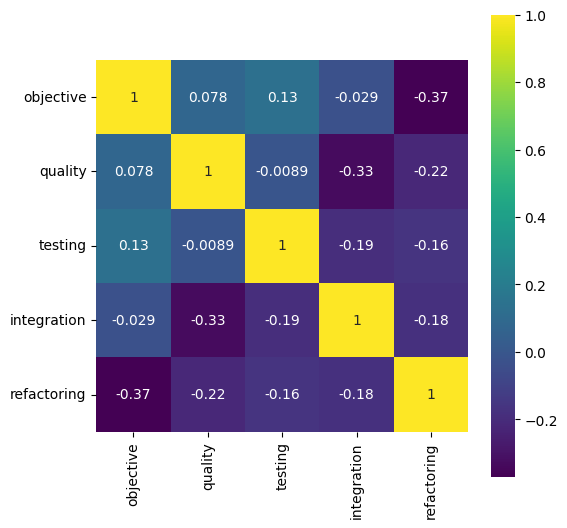

In [ ]:
import seaborn as sns
plt.figure(figsize = (6,6))
sns.heatmap(cleaned_df[features].corr(), cmap='viridis', annot=True, square=True)
plt.show()

### There are no strong correlations. The highest magnitude is 0.37, which is considered a low correlation.

### So now we can, for example, train a binary classifier for each of these five categories. So based on the review subject and/or the review description does the review belong to the 'objective' category, or not? Does it belong to the 'quality' category, or not?, etc.

# Step 2: Visualize common subject and description words

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import string

stop_set = set(stopwords.words('english')+ list(string.punctuation))
snowball = SnowballStemmer('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
subject_cat = cleaned_df.subject.str.cat(sep=' ')
subject_tokens = word_tokenize(subject_cat.lower())
subject_tokens = [w for w in subject_tokens if not w in stop_set]
subject_stem = []
for t in subject_tokens:
  subject_stem.append(snowball.stem(t))

subject_stem = [i for i in subject_stem if i != 'refactor'] #This was a selection criteria, so will be in every item by definition, so provides no information.
print('Total number of subject words:', len(subject_stem))
subject_vocab = set(subject_stem)
print('Size of subject voabulary:', len(subject_vocab))

Total number of subject words: 6370
Size of subject voabulary: 1891


In [ ]:
description_cat = cleaned_df.description.str.cat(sep=' ')
description_tokens = word_tokenize(description_cat.lower())
description_tokens = [w for w in description_tokens if not w in stop_set]
description_stem = []
for t in description_tokens:
  description_stem.append(snowball.stem(t))

description_stem = [i for i in description_stem if i != 'refactor'] #This was a selection criteria, so will be in every item by definition, so provides no information.
print('Total number of description words:', len(description_stem))
description_vocab = set(description_stem)
print('Size of description vocabulary:', len(description_vocab))

Total number of description words: 60377
Size of description vocabulary: 9208


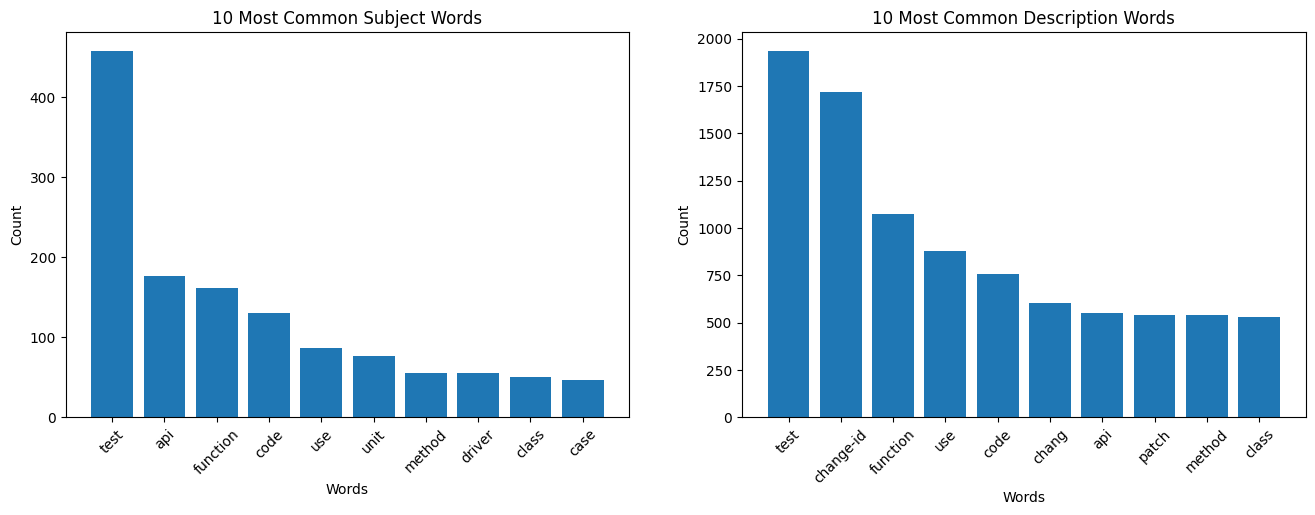

In [ ]:
subject_freq = nltk.FreqDist(subject_stem)
description_freq = nltk.FreqDist(description_stem)

subject_words, subject_frequencies = zip(*subject_freq.most_common(10))
desc_words, desc_frequencies = zip(*description_freq.most_common(10))

fig, axs = plt.subplots(1,2, figsize=(16, 5))

axs[0].bar(subject_words, subject_frequencies)
axs[0].set_title('10 Most Common Subject Words')
axs[0].set_xticks(subject_words)
axs[0].set_xticklabels(subject_words, rotation=45)

axs[1].bar(desc_words, desc_frequencies)
axs[1].set_title('10 Most Common Description Words')
axs[1].set_xticks(desc_words)
axs[1].set_xticklabels(desc_words, rotation=45)

for ax in axs:
    ax.set_xlabel('Words')
    ax.set_ylabel('Count')

plt.show()

# Step 3: Train a Simple Binary Classifier Based on TF-IDF

### Note that we will work with the 'quality' column first because it is the most balanced class.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cleaned_df[['subject','description']], cleaned_df.quality, random_state=123)

#tfidf_vect = TfidfVectorizer(vocabulary=subject_vocab)
tfidf_vect = TfidfVectorizer()
X_train_vect = tfidf_vect.fit_transform(X_train.subject)
X_test_vect = tfidf_vect.transform(X_test.subject)

print(X_train_vect.shape)
#print(X_train_vect[0][0:3])
print(tfidf_vect.get_feature_names_out())

#tfidf_vect2 = TfidfVectorizer(vocabulary=description_vocab)
tfidf_vect2 = TfidfVectorizer()
X_train_vect2 = tfidf_vect2.fit_transform(X_train.description)
X_test_vect2 = tfidf_vect2.transform(X_test.description)

print(X_train_vect2.shape)
#print(X_train_vect2[0][0:3])
print(tfidf_vect2.get_feature_names_out())

(1279, 1812)
['10' '11' '1204824' ... 'zun' 'zunclient' 'zuul']
(1279, 8165)
['000' '02617682aa53fc55cf21338ad85d18444c5ccc59' '04' ... 'zun_url'
 'zunclient' 'zuul']


### The paper by Herbold et al. (2020) generates a combined probability from (subject probability + description probability) / 2, and then classifies based on the combined probability, so we test out that approach below. We report the accuracies of the subject classifications, the description classifications, and the combined classifications

In [ ]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from  sklearn.metrics  import accuracy_score

clf = ComplementNB().fit(X_train_vect, y_train)
predicted_bin_subj = clf.predict(X_test_vect)
predicted_prob_subj = clf.predict_proba(X_test_vect)
print('Subject accuracy:', accuracy_score(y_test,predicted_bin_subj))

clf2 = ComplementNB().fit(X_train_vect2, y_train)
predicted_bin_desc = clf2.predict(X_test_vect2)
predicted_prob_desc = clf2.predict_proba(X_test_vect2)
print('Description accuracy:', accuracy_score(y_test,predicted_bin_desc))

predicted_prob_comb = (predicted_prob_subj + predicted_prob_desc) / 2.0
predicted_bin_comb = np.argmax(predicted_prob_comb, axis=1)
print('Combined accuracy:', accuracy_score(y_test,predicted_bin_comb))

Subject accuracy: 0.6112412177985949
Description accuracy: 0.6814988290398126
Combined accuracy: 0.6932084309133489


### We want to report metrics for precision, recall, and f1 score in addition to accuracy. Check these three metrics for the subject classifier, the description classifier, and the combined classifier.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
print('Subject precision, recall, f1 score: ',precision_recall_fscore_support(y_test,predicted_bin_subj, average='binary', pos_label=1)[0:3])
print('Description precision, recall, f1 score:', precision_recall_fscore_support(y_test,predicted_bin_desc, average='binary', pos_label=1)[0:3])
print('Combined precision, recall, f1 score:', precision_recall_fscore_support(y_test,predicted_bin_comb, average='binary', pos_label=1)[0:3])

Subject precision, recall, f1 score:  (0.6442307692307693, 0.5929203539823009, 0.6175115207373272)
Description precision, recall, f1 score: (0.6371951219512195, 0.9247787610619469, 0.7545126353790613)
Combined precision, recall, f1 score: (0.6588628762541806, 0.8716814159292036, 0.7504761904761905)


### Also plot the confusion matrices for the subject classifier, the description classifier, and the combined classifier.

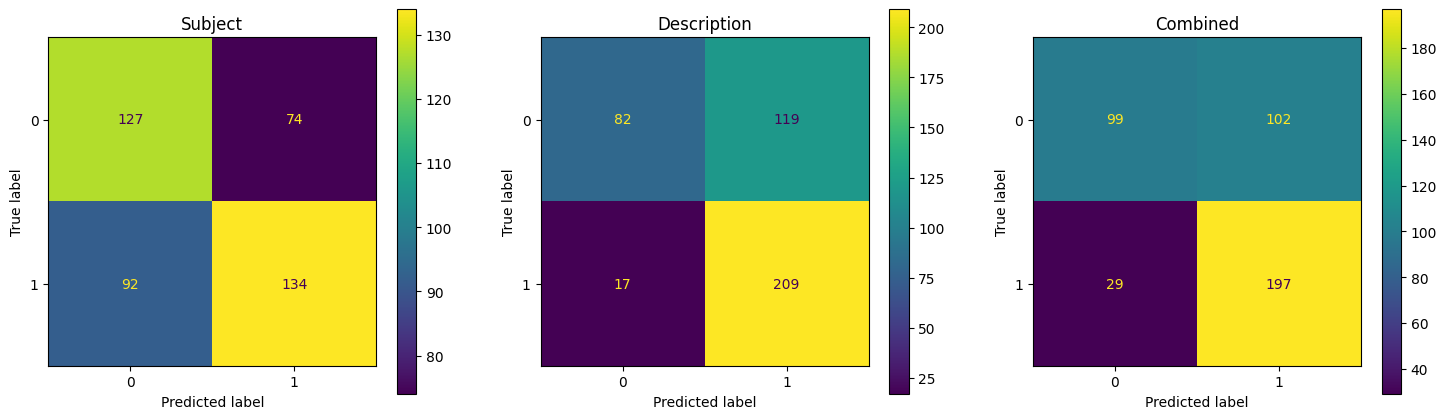

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axs = plt.subplots(1,3, figsize=(18, 5))

ConfusionMatrixDisplay.from_predictions(y_test, predicted_bin_subj, ax=axs[0])
ConfusionMatrixDisplay.from_predictions(y_test, predicted_bin_desc, ax=axs[1])
ConfusionMatrixDisplay.from_predictions(y_test, predicted_bin_comb, ax=axs[2])

axs[0].set_title('Subject')
axs[1].set_title('Description')
axs[2].set_title('Combined')

plt.show()